In [0]:
%pip install --upgrade --force-reinstall -r https://aka.ms/automl_linux_requirements.txt

Python interpreter will be restarted.
Collecting adal<=1.2.6
 Using cached adal-1.2.6-py2.py3-none-any.whl (55 kB)
Collecting applicationinsights<=0.11.9
 Using cached applicationinsights-0.11.9-py2.py3-none-any.whl (58 kB)
Collecting azure-common<=1.1.26
 Using cached azure_common-1.1.26-py2.py3-none-any.whl (12 kB)
Collecting azure-core<=1.12.0
 Using cached azure_core-1.12.0-py2.py3-none-any.whl (130 kB)
Collecting azure-graphrbac<=0.61.1
 Using cached azure_graphrbac-0.61.1-py2.py3-none-any.whl (141 kB)
Collecting azure-identity<=1.4.1
 Using cached azure_identity-1.4.1-py2.py3-none-any.whl (86 kB)
Collecting azure-mgmt-authorization<=0.61.0
 Using cached azure_mgmt_authorization-0.61.0-py2.py3-none-any.whl (94 kB)
Collecting azure-mgmt-containerregistry<=2.8.0
 Using cached azure_mgmt_containerregistry-2.8.0-py2.py3-none-any.whl (718 kB)
Collecting azure-mgmt-keyvault<=2.2.0
 Using cached azure_mgmt_keyvault-2.2.0-py2.py3-none-any.whl (89 kB)
Collecting azure-mgmt-resource<=12.1.0
 Using cached azure_mgmt_resource-12.1.0-py2.py3-none-any.whl (1.1 MB)
Collecting azure-mgmt-storage<=11.2.0
 Using cached azure_mgmt_storage-11.2.0-py2.py3-none-any.whl (547 kB)
Collecting azure-storage-queue<=12.1.5
 Using cached azure_storage_queue-12.1.5-py2.py3-none-any.whl (132 kB)
Collecting azureml-automl-core~=1.25.0
 Using cached azureml_automl_core-1.25.0-py3-none-any.whl (196 kB)
Collecting azureml-automl-runtime~=1.25.0
 Using cached azureml_automl_runtime-1.25.0-py3-none-any.whl (2.0 MB)
Collecting azureml-core~=1.25.0
 Using cached azureml_core-1.25.0-py3-none-any.whl (2.2 MB)
Collecting azureml-dataprep<=2.11.2
 Using cached azureml_dataprep-2.11.2-py3-none-any.whl (39.4 MB)
Collecting azureml-dataprep-native<=30.0.0
 Using cached azureml_dataprep_native-30.0.0-cp37-cp37m-manylinux1_x86_64.whl (1.3 MB)
Collecting azureml-dataprep-rslex<=1.9.1
 Using cached azureml_dataprep_rslex-1.9.1-cp37-cp37m-manylinux2010_x86_64.whl (9.0 MB)
Collecting azureml-dataset-runtime~=1.25.0
 Using cached azureml_dataset_runtime-1.25.0-py3-none-any.whl (3.4 kB)
Collecting azureml-defaults~=1.25.0
 Using cached azureml_defaults-1.25.0-py3-none-any.whl (3.1 kB)
Collecting azureml-interpret~=1.25.0
 Using cached azureml_interpret-1.25.0-py3-none-any.whl (51 kB)
Collecting azureml-model-management-sdk<=1.0.1b6.post1
 Using cached azureml_model_management_sdk-1.0.1b6.post1-py2.py3-none-any.whl (130 kB)
Collecting azureml-pipeline-core~=1.25.0
 Using cached azureml_pipeline_core-1.25.0-py3-none-any.whl (309 kB)
Collecting azureml-pipeline-steps~=1.25.0
 Using cached azureml_pipeline_steps-1.25.0-py3-none-any.whl (68 kB)
Collecting azureml-telemetry~=1.25.0
 Using cached azureml_telemetry-1.25.0-py3-none-any.whl (30 kB)
Collecting azureml-train-automl~=1.25.0
 Using cached azureml_train_automl-1.25.0-py3-none-any.whl (3.4 kB)
Collecting azureml-train-automl-client~=1.25.0
 Using cached azureml_train_automl_client-1.25.0-py3-none-any.whl (117 kB)
Collecting azureml-train-automl-runtime~=1.25.0
 Using cached azureml_train_automl_runtime-1.25.0-py3-none-any.whl (143 kB)
Collecting azureml-train-core~=1.25.0
 Using cached azureml_train_core-1.25.0-py3-none-any.whl (8.6 MB)
Collecting azureml-train-restclients-hyperdrive~=1.25.0
 Using cached azureml_train_restclients_hyperdrive-1.25.0-py3-none-any.whl (19 kB)
Collecting backports.tempfile<=1.0
 Using cached backports.tempfile-1.0-py2.py3-none-any.whl (4.4 kB)
Collecting backports.weakref<=1.0.post1
 Using cached backports.weakref-1.0.post1-py2.py3-none-any.whl (5.2 kB)
Collecting boto<=2.49.0
 Using cached boto-2.49.0-py2.py3-none-any.whl (1.4 MB)
Collecting boto3<=1.15.18
 Using cached boto3-1.15.18-py2.py3-none-any.whl (129 kB)
Collecting botocore<=1.18.18
 Using cached botocore-1.18.18-py2.py3-none-any.whl (6.7 MB)
Collecting certifi<=2020.12.5
 Using cached certifi-2020.12.5-py2.py3-none-any.whl (147 kB)
Collecting cffi<=1.14.5
 Using cached cffi-1.14.5-cp37-cp37m-manylinux1_x86_64.whl (402 kB)
Collecting c

In [0]:
import azureml.core

print("SDK Version:", azureml.core.VERSION)


SDK Version: 1.25.0

In [0]:
# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
# dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
# dbutils.widgets.dropdown("new_training", "False", ["True","False"])
# dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name)

dev bimodelapi True cc-bi-ml-devqa01

dev bimodelapi True cc-bi-ml-devqa01

dev bimodelapi True cc-bi-ml-devqa01

EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
End_of_Month 63 non-null datetime64[ns]
EURONEXT_100 63 non-null float64
FTSE_100 63 non-null float64
Nikkei_225 63 non-null float64
SP_500 63 non-null float64
SSE_Composite_Index 63 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.1 KB

End_of_Month,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
2020-11-30T00:00:00.000+0000,1088.72998046875,6266.2001953125,26433.619140625,3621.6298828125,3391.760009765625
2020-12-31T00:00:00.000+0000,1103.5400390625,6460.5,27444.169921875,3756.070068359375,3473.069091796875
2021-01-31T00:00:00.000+0000,1085.3800048828125,6407.5,27663.390625,3714.239990234375,3483.069091796875
2021-02-28T00:00:00.000+0000,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125
2021-03-31T00:00:00.000+0000,1172.469970703125,6699.2001953125,28405.51953125,3910.52001953125,3411.510009765625


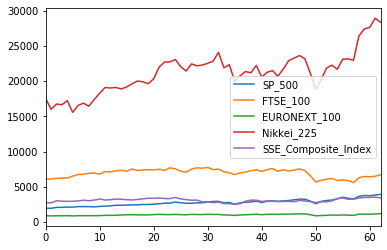

pipehist : (80096, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80096 entries, 0 to 80095
Data columns (total 9 columns):
Snapshot_Date_Short 80096 non-null datetime64[ns]
Relative_Snapshot_Month_Offset 80096 non-null int64
End_of_Month 80096 non-null datetime64[ns]
Relative_Month_Offset 80096 non-null int64
Sub_Region_Code 78853 non-null object
Pipeline_Type 80096 non-null object
Pipeline 80005 non-null object
Yield 61678 non-null float64
Yield_Amount 64423 non-null object
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 5.5+ MB
/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field Sub_Region_Code. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion from Arrow: null
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline_Type,Pipeline,Yield,Yield_Amount
2020-10-11T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NaN,Opportunity,130789.38,NaN,NaN
2020-10-11T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NaN,Opportunity,143245.52,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-10-31T00:00:00.000+0000,-5,NaN,Opportunity,62280.66,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NaN,Opportunity,130789.38,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NaN,Opportunity,143245.52,NaN,NaN


talenthist : (2526, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 5 columns):
End_of_Month 2526 non-null datetime64[ns]
Sub_Region_Code 2430 non-null object
Journey_Level 2526 non-null object
Headcount 2150 non-null float64
Headcount_Contingent 892 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 98.8+ KB

End_of_Month,Sub_Region_Code,Journey_Level,Headcount,Headcount_Contingent
2017-01-31T00:00:00.000+0000,Global,Team,19.0,null
2017-01-31T00:00:00.000+0000,Global,Director,11.5,null
2017-01-31T00:00:00.000+0000,Global,Enterprise,15.8,null
2017-01-31T00:00:00.000+0000,Global,Unknown,1.0,5.0
2017-01-31T00:00:00.000+0000,null,Unknown,null,5.0


revhist : (415, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 3 columns):
End_of_Month 415 non-null datetime64[ns]
Sub_Region_Code 414 non-null object
Revenue 415 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 9.9+ KB

End_of_Month,Sub_Region_Code,Revenue
2021-04-30T00:00:00.000+0000,Play Lab,250000.00
2021-05-31T00:00:00.000+0000,Academy,960645.00
2021-05-31T00:00:00.000+0000,Play Lab,125000.00
2021-06-30T00:00:00.000+0000,Academy,48000.00
2021-06-30T00:00:00.000+0000,Play Lab,50000.00


opphist : (593, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 7 columns):
End_of_Month 593 non-null datetime64[ns]
Sub_Region_Code 527 non-null object
Opportunity_Period_Count 256 non-null float64
Opportunity_Count 593 non-null int64
Current_Opp._Period_Value 242 non-null float64
Opportunity_Value 584 non-null float64
Win_Rate 189 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 32.6+ KB

End_of_Month,Sub_Region_Code,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate
2023-12-31T00:00:00.000+0000,Academy,null,4,null,14925.0,null
2023-12-31T00:00:00.000+0000,Centers of Excellence,null,11,null,1300000.0,null
2023-12-31T00:00:00.000+0000,Play Lab,null,6,null,1094000.0,null
2023-12-31T00:00:00.000+0000,Global,null,2,null,233601.0,null
2023-12-31T00:00:00.000+0000,null,null,11,null,2267016.0,null


projhist : (639, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 5 columns):
End_of_Month 639 non-null datetime64[ns]
Sub_Region_Code 636 non-null object
Project_Period_Price 369 non-null float64
Project_Price 638 non-null float64
Conversions 320 non-null object
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 25.1+ KB
/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field Conversions. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion from Arrow: null
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

End_of_Month,Sub_Region_Code,Project_Period_Price,Project_Price,Conversions
2023-12-31T00:00:00.000+0000,North America,NaN,1.17131827E8,NaN
2023-12-31T00:00:00.000+0000,Europe,NaN,1.538432393E7,NaN
2023-12-31T00:00:00.000+0000,Centers of Excellence,NaN,8438954.0,NaN
2023-12-31T00:00:00.000+0000,Play Lab,NaN,1388384.0,NaN
2023-12-31T00:00:00.000+0000,Global,NaN,8913323.0,NaN


pipetrend : (12823, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823 entries, 0 to 12822
Data columns (total 5 columns):
Snapshot_Date_Short 12823 non-null datetime64[ns]
End_of_Month 12823 non-null datetime64[ns]
Sub_Region_Code 12306 non-null object
Pipeline_Type 12823 non-null object
Pipeline_Trend 12823 non-null object
dtypes: datetime64[ns](2), object(3)
memory usage: 501.0+ KB

Snapshot_Date_Short,End_of_Month,Sub_Region_Code,Pipeline_Type,Pipeline_Trend
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Active Unrecognized,354467.35
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Opportunity,46803.36
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Active Unrecognized,342912.09
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Opportunity ML,54484.25
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,null,Opportunity,256717.84


x : (80096, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80096 entries, 0 to 80095
Data columns (total 9 columns):
Snapshot_Date 80096 non-null datetime64[ns]
Relative_Snapshot_Month_Offset 80096 non-null int64
End_of_Month 80096 non-null datetime64[ns]
Relative_Month_Offset 80096 non-null int64
Sub_Region_Code 80096 non-null object
Pipeline_Type 80096 non-null object
Pipeline 80096 non-null float64
Yield 80096 non-null float64
Yield_Amount 80096 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(2)
memory usage: 5.5+ MB

Snapshot_Date,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline_Type,Pipeline,Yield,Yield_Amount
2020-10-11T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NA,Opportunity,130789.38,0.0,0.0
2020-10-11T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NA,Opportunity,143245.52,0.0,0.0
2020-10-18T00:00:00.000+0000,-5,2020-10-31T00:00:00.000+0000,-5,NA,Opportunity,62280.66,0.0,0.0
2020-10-18T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NA,Opportunity,130789.38,0.0,0.0
2020-10-18T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NA,Opportunity,143245.52,0.0,0.0


x : (2526, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 4 columns):
End_of_Month 2526 non-null datetime64[ns]
Sub_Region_Code 2526 non-null object
Journey_Level 2526 non-null object
Billable_Headcount 2526 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 79.1+ KB

End_of_Month,Sub_Region_Code,Journey_Level,Billable_Headcount
2017-01-31T00:00:00.000+0000,Global,Team,0.0
2017-01-31T00:00:00.000+0000,Global,Director,0.0
2017-01-31T00:00:00.000+0000,Global,Enterprise,0.0
2017-01-31T00:00:00.000+0000,Global,Unknown,6.0
2017-01-31T00:00:00.000+0000,NA,Unknown,0.0


x : (415, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 3 columns):
End_of_Month 415 non-null datetime64[ns]
Sub_Region_Code 415 non-null object
Revenue 415 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.9+ KB

End_of_Month,Sub_Region_Code,Revenue
2021-04-30T00:00:00.000+0000,Play Lab,250000.0
2021-05-31T00:00:00.000+0000,Academy,960645.0
2021-05-31T00:00:00.000+0000,Play Lab,125000.0
2021-06-30T00:00:00.000+0000,Academy,48000.0
2021-06-30T00:00:00.000+0000,Play Lab,50000.0


x : (593, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 7 columns):
End_of_Month 593 non-null datetime64[ns]
Sub_Region_Code 593 non-null object
Opportunity_Period_Count 593 non-null float64
Opportunity_Count 593 non-null int64
Current_Opp._Period_Value 593 non-null float64
Opportunity_Value 593 non-null float64
Win_Rate 593 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 32.6+ KB

End_of_Month,Sub_Region_Code,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate
2023-12-31T00:00:00.000+0000,Academy,0.0,4,0.0,14925.0,0.0
2023-12-31T00:00:00.000+0000,Centers of Excellence,0.0,11,0.0,1300000.0,0.0
2023-12-31T00:00:00.000+0000,Play Lab,0.0,6,0.0,1094000.0,0.0
2023-12-31T00:00:00.000+0000,Global,0.0,2,0.0,233601.0,0.0
2023-12-31T00:00:00.000+0000,NA,0.0,11,0.0,2267016.0,0.0


x : (639, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 5 columns):
End_of_Month 639 non-null datetime64[ns]
Sub_Region_Code 639 non-null object
Project_Period_Price 639 non-null float64
Project_Price 639 non-null float64
Conversions 639 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 25.1+ KB

End_of_Month,Sub_Region_Code,Project_Period_Price,Project_Price,Conversions
2023-12-31T00:00:00.000+0000,North America,0.0,1.17131827E8,0.0
2023-12-31T00:00:00.000+0000,Europe,0.0,1.538432393E7,0.0
2023-12-31T00:00:00.000+0000,Centers of Excellence,0.0,8438954.0,0.0
2023-12-31T00:00:00.000+0000,Play Lab,0.0,1388384.0,0.0
2023-12-31T00:00:00.000+0000,Global,0.0,8913323.0,0.0


x : (12823, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823 entries, 0 to 12822
Data columns (total 5 columns):
Snapshot_Date 12823 non-null datetime64[ns]
End_of_Month 12823 non-null datetime64[ns]
Sub_Region_Code 12823 non-null object
Pipeline_Type 12823 non-null object
Pipeline_Trend 12823 non-null float64
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 501.0+ KB

Snapshot_Date,End_of_Month,Sub_Region_Code,Pipeline_Type,Pipeline_Trend
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Active Unrecognized,354467.35
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Opportunity,46803.36
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Active Unrecognized,342912.09
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Opportunity ML,54484.25
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,NA,Opportunity,256717.84


eom_region_snp1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 6 columns):
End_of_Month 5568 non-null datetime64[ns]
Snapshot_Date 5568 non-null datetime64[ns]
Sub_Region_Code 5568 non-null object
Relative_Month_Offset 5568 non-null int64
Relative_Snapshot_Month_Offset 5568 non-null int64
Relative_Offset 5568 non-null int64
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 261.1+ KB

End_of_Month,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Europe,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Global,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Japan,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,North America,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Play Lab,3,0,3


eom_region_snp2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 4 columns):
End_of_Month 696 non-null datetime64[ns]
Relative_Offset 696 non-null int64
Snapshot_Date 696 non-null datetime64[ns]
Snp_Seq_No 696 non-null int64
dtypes: datetime64[ns](2), int64(2)
memory usage: 21.9 KB

End_of_Month,Relative_Offset,Snapshot_Date,Snp_Seq_No
2021-06-30T00:00:00.000+0000,3,2021-03-20T00:00:00.000+0000,7
2021-06-30T00:00:00.000+0000,3,2021-03-21T00:00:00.000+0000,8
2021-06-30T00:00:00.000+0000,3,2021-03-22T00:00:00.000+0000,9
2021-06-30T00:00:00.000+0000,3,2021-03-23T00:00:00.000+0000,10
2021-06-30T00:00:00.000+0000,3,2021-03-24T00:00:00.000+0000,11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 1 columns):
Snp_Seq_No 7 non-null int64
dtypes: int64(1)
memory usage: 184.0 bytes
eom_region_snp3:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 4 columns):
Snp_Seq_No 676 non-null int64
End_of_Month 676 non-null datetime64[ns]
Relative_Offset 676 non-null int64
Snapshot_Date 676 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 21.2 KB

Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date
5,2021-06-30T00:00:00.000+0000,3,2021-03-18T00:00:00.000+0000
6,2021-03-31T00:00:00.000+0000,0,2021-03-19T00:00:00.000+0000
6,2021-04-30T00:00:00.000+0000,1,2021-03-19T00:00:00.000+0000
6,2021-05-31T00:00:00.000+0000,2,2021-03-19T00:00:00.000+0000
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000


eom_region_snp_final:

Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Europe,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Global,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Japan,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,North America,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Play Lab,3,0


EOM : (54, 1)
Region Shape: (10, 1)
Snapthot Shape: (174, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5408 entries, 0 to 5407
Data columns (total 7 columns):
Snp_Seq_No 5408 non-null int64
End_of_Month 5408 non-null datetime64[ns]
Relative_Offset 5408 non-null int64
Snapshot_Date 5408 non-null datetime64[ns]
Sub_Region_Code 5408 non-null object
Relative_Month_Offset 5408 non-null int64
Relative_Snapshot_Month_Offset 5408 non-null int64
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 295.9+ KB
EOM_Region Shape: None
[0 1 2 3 4 5 6]

Out[13]:

Snapshot_Date 
 
 
 
 Snp_Seq_No 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 
 
 
 Sub_Region_Code 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 
 
 End_of_Month 
 Relative_Offset 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2018-07-31 
 0 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 2018-08-31 
 0 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 1 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 2018-09-30 
 0 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 1 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2021-04-30 
 2 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 3 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 2021-05-31 
 2 
 1.00 
 1.00 
 

Out[14]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset
0,0,2018-07-31,0,2018-07-20,Academy,-32,-32
1,0,2018-07-31,0,2018-07-20,Centers of Excellence,-32,-32
2,0,2018-07-31,0,2018-07-20,China,-32,-32
3,0,2018-07-31,0,2018-07-20,Europe,-32,-32
4,0,2018-07-31,0,2018-07-20,Global,-32,-32
...,...,...,...,...,...,...,...
5403,6,2021-06-30,3,2021-03-19,Europe,3,0
5404,6,2021-06-30,3,2021-03-19,Global,3,0
5405,6,2021-06-30,3,2021-03-19,Japan,3,0
5406,6,2021-06-30,3,2021-03-19,North America,3,0


Billable_Headcount_Director,Billable_Headcount_Enterprise,Billable_Headcount_Individual,Billable_Headcount_Team,Billable_Headcount_Temp,Billable_Headcount_Unknown
0.0,0.0,15.0,0.0,0.0,0.0
0.0,0.0,23.0,12.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,134.75,117.2,0.0,8.0
0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 8 columns):
End_of_Month 578 non-null datetime64[ns]
Sub_Region_Code 578 non-null object
Billable_HC_Enterprise 578 non-null int64
Billable_HC_Director 578 non-null int64
Billable_HC_Team 578 non-null int64
Billable_HC_Individual 578 non-null int64
Billable_HC_Temp 578 non-null int64
Billable_HC_Unknown 578 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 36.2+ KB
talenthist_wide: (578, 8)
Out[15]:

,End_of_Month,Sub_Region_Code,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown
573,2022-02-28,Global,0,0,15,0,0,0
574,2022-02-28,Japan,0,0,23,12,0,0
575,2022-02-28,NA,0,0,0,0,0,0
576,2022-02-28,North America,0,0,134,117,0,8
577,2022-02-28,Play Lab,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 6 columns):
End_of_Month 4864 non-null datetime64[ns]
Snapshot_Date 4864 non-null datetime64[ns]
Sub_Region_Code 4864 non-null object
Active_Unrecognized_Trend 4864 non-null int64
Opportunity_Trend 4864 non-null int64
Opportunity_ML_Trend 4864 non-null int64
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 228.1+ KB
Pipehist_wide: (4864, 6)
Out[16]:

,End_of_Month,Snapshot_Date,Sub_Region_Code,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
4859,2021-06-30,2021-03-24,Global,342912,0,54484
4860,2021-06-30,2021-03-24,Japan,1087775,257881,1209190
4861,2021-06-30,2021-03-24,NA,0,256717,0
4862,2021-06-30,2021-03-24,North America,12399838,3592839,11115719
4863,2021-06-30,2021-03-24,Play Lab,354467,46803,0


merge_df: (5408, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5408 entries, 0 to 5407
Data columns (total 22 columns):
Snp_Seq_No 5408 non-null int64
End_of_Month 5408 non-null datetime64[ns]
Relative_Offset 5408 non-null int64
Snapshot_Date 5408 non-null datetime64[ns]
Sub_Region_Code 5408 non-null object
Relative_Month_Offset 5408 non-null int64
Relative_Snapshot_Month_Offset 5408 non-null int64
Revenue 5408 non-null float64
Billable_HC_Enterprise 5408 non-null int64
Billable_HC_Director 5408 non-null int64
Billable_HC_Team 5408 non-null int64
Billable_HC_Individual 5408 non-null int64
Billable_HC_Temp 5408 non-null int64
Billable_HC_Unknown 5408 non-null int64
Opportunity_Period_Count 5408 non-null float64
Opportunity_Count 5408 non-null float64
Current_Opp._Period_Value 5408 non-null float64
Opportunity_Value 5408 non-null float64
Win_Rate 5408 non-null float64
Project_Period_Price 5408 non-null float64
Project_Price 5408 non-null float64
Conversions 5408 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(10), object(1)
memory usage: 971.8+ KB
(5408, 22)
Out[17]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions
5403,6,2021-06-30,3,2021-03-19,Europe,3,0,0.00,0,0,26,0,0,0,0.00,38.00,0.00,12193828.76,0.00,0.00,15384323.93,0.00
5404,6,2021-06-30,3,2021-03-19,Global,3,0,0.00,0,0,15,0,0,0,0.00,2.00,0.00,233601.00,0.00,0.00,8913323.00,0.00
5405,6,2021-06-30,3,2021-03-19,Japan,3,0,0.00,0,0,23,12,0,0,0.00,26.00,0.00,4958396.00,0.00,0.00,8581027.14,0.00
5406,6,2021-06-30,3,2021-03-19,North America,3,0,0.00,0,0,134,118,0,26,0.00,193.00,0.00,66867564.00,0.00,0.00,117131827.00,0.00
5407,6,2021-06-30,3,2021-03-19,Play Lab,3,0,50000.00,0,0,0,0,0,0,0.00,6.00,0.00,1094000.00,0.00,0.00,1388384.00,0.00


(5408, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5408 entries, 0 to 5407
Data columns (total 27 columns):
Snp_Seq_No 5408 non-null int64
End_of_Month 5408 non-null datetime64[ns]
Relative_Offset 5408 non-null int64
Snapshot_Date 5408 non-null datetime64[ns]
Sub_Region_Code 5408 non-null object
Relative_Month_Offset 5408 non-null int64
Relative_Snapshot_Month_Offset 5408 non-null int64
Revenue 5408 non-null float64
Billable_HC_Enterprise 5408 non-null int64
Billable_HC_Director 5408 non-null int64
Billable_HC_Team 5408 non-null int64
Billable_HC_Individual 5408 non-null int64
Billable_HC_Temp 5408 non-null int64
Billable_HC_Unknown 5408 non-null int64
Opportunity_Period_Count 5408 non-null float64
Opportunity_Count 5408 non-null float64
Current_Opp._Period_Value 5408 non-null float64
Opportunity_Value 5408 non-null float64
Win_Rate 5408 non-null float64
Project_Period_Price 5408 non-null float64
Project_Price 5408 non-null float64
Conversions 5408 non-null float64
EURONEXT_100 5408 non-null float64
FTSE_100 5408 non-null float64
Nikkei_225 5408 non-null float64
SP_500 5408 non-null float64
SSE_Composite_Index 5408 non-null float64
dtypes: datetime64[ns](2), float64(14), int64(10), object(1)
memory usage: 1.1+ MB
Out[18]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
5403,6,2021-06-30,3,2021-03-19,Europe,3,0,0.00,0,0,26,0,0,0,0.00,38.00,0.00,12193828.76,0.00,0.00,15384323.93,0.00,0.00,0.00,0.00,0.00,0.00
5404,6,2021-06-30,3,2021-03-19,Global,3,0,0.00,0,0,15,0,0,0,0.00,2.00,0.00,233601.00,0.00,0.00,8913323.00,0.00,0.00,0.00,0.00,0.00,0.00
5405,6,2021-06-30,3,2021-03-19,Japan,3,0,0.00,0,0,23,12,0,0,0.00,26.00,0.00,4958396.00,0.00,0.00,8581027.14,0.00,0.00,0.00,0.00,0.00,0.00
5406,6,2021-06-30,3,2021-03-19,North America,3,0,0.00,0,0,134,118,0,26,0.00,193.00,0.00,66867564.00,0.00,0.00,117131827.00,0.00,0.00,0.00,0.00,0.00,0.00
5407,6,2021-06-30,3,2021-03-19,Play Lab,3,0,50000.00,0,0,0,0,0,0,0.00,6.00,0.00,1094000.00,0.00,0.00,1388384.00,0.00,0.00,0.00,0.00,0.00,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63753 entries, 0 to 63752
Data columns (total 17 columns):
Snapshot_Date 63753 non-null datetime64[ns]
Relative_Snapshot_Month_Offset 63753 non-null int64
End_of_Month 63753 non-null datetime64[ns]
Relative_Month_Offset 63753 non-null int64
Sub_Region_Code 63753 non-null object
Active_Unrecognized 63753 non-null int64
Opportunity 63753 non-null int64
Opportunity_ML 63753 non-null int64
Recognized 63753 non-null int64
Yield_Active_Unrecog 63753 non-null float64
Yield_Opp 63753 non-null float64
Yield_Opp_ML 63753 non-null float64
Yield_Recog 63753 non-null float64
Yield_Amount_Active_Unrecog 63753 non-null int64
Yield_Amount_Opp 63753 non-null int64
Yield_Amount_Opp_ML 63753 non-null int64
Yield_Amount_Recog 63753 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(10), object(1)
memory usage: 8.3+ MB
Pipehist_wide: (63753, 17)
Out[19]:

,Snapshot_Date,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog
63748,2021-03-23,0,2022-02-28,11,North America,8997,313398,238683,0,-0.45,0.00,0.40,0.00,0,0,112281,0
63749,2021-03-24,0,2022-02-28,11,Centers of Excellence,54322,0,0,0,-0.49,0.00,0.00,0.00,0,0,0,0
63750,2021-03-24,0,2022-02-28,11,Europe,63102,119082,0,0,-0.01,0.00,0.00,0.00,0,0,0,0
63751,2021-03-24,0,2022-02-28,11,NA,0,78990,0,0,0.00,0.00,0.00,0.00,0,0,0,0
63752,2021-03-24,0,2022-02-28,11,North America,8997,266645,238683,0,-0.45,0.00,0.40,0.00,0,0,112281,0


Snapshot_Date,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
2021-03-23T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,North America,8997,313398,238683,0,-0.4495,0.0,0.401,0.0,0,0,112281,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,Centers of Excellence,54322,0,0,0,-0.4888,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,Europe,63102,119082,0,0,-0.014,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,NA,0,78990,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,North America,8997,266645,238683,0,-0.4495,0.0,0.401,0.0,0,0,112281,0,0.0,0.0,0.0


Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Europe,3,0,0.0,0,0,26,0,0,0,0.0,38.0,0.0,1.219382876E7,0.0,0.0,1.538432393E7,0.0,0.0,0.0,0.0,0.0,0.0,877851.0,204976.0,275426.0,0.0,0.0954,0.0,0.5402,0.0,76428.0,0.0,137372.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Global,3,0,0.0,0,0,15,0,0,0,0.0,2.0,0.0,233601.0,0.0,0.0,8913323.0,0.0,0.0,0.0,0.0,0.0,0.0,141548.0,0.0,15913.0,0.0,0.0849,0.0,0.5087,0.0,10963.0,0.0,7153.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Japan,3,0,0.0,0,0,23,12,0,0,0.0,26.0,0.0,4958396.0,0.0,0.0,8581027.14,0.0,0.0,0.0,0.0,0.0,0.0,179609.0,178997.0,491743.0,0.0,-0.2163,0.0,0.4206,0.0,0.0,0.0,161758.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,North America,3,0,0.0,0,0,134,118,0,26,0.0,193.0,0.0,6.6867564E7,0.0,0.0,1.17131827E8,0.0,0.0,0.0,0.0,0.0,0.0,1860909.0,1987516.0,3165585.0,0.0,-0.0348,0.0,0.0732,0.0,0.0,0.0,378061.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Play Lab,3,0,50000.0,0,0,0,0,0,0,0.0,6.0,0.0,1094000.0,0.0,0.0,1388384.0,0.0,0.0,0.0,0.0,0.0,0.0,49870.0,17452.0,0.0,50000.0,-0.1646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


merge_final: (5408, 42)
['2018-07-20T00:00:00.000000000' '2018-07-22T00:00:00.000000000'
 '2018-07-29T00:00:00.000000000' '2018-07-31T00:00:00.000000000'
 '2018-08-05T00:00:00.000000000' '2018-08-12T00:00:00.000000000'
 '2018-08-19T00:00:00.000000000' '2018-08-26T00:00:00.000000000'
 '2018-08-31T00:00:00.000000000' '2018-09-09T00:00:00.000000000'
 '2018-09-16T00:00:00.000000000' '2018-09-23T00:00:00.000000000'
 '2018-09-30T00:00:00.000000000' '2018-10-07T00:00:00.000000000'
 '2018-10-14T00:00:00.000000000' '2018-10-21T00:00:00.000000000'
 '2018-10-28T00:00:00.000000000' '2018-10-31T00:00:00.000000000'
 '2018-11-04T00:00:00.000000000' '2018-11-11T00:00:00.000000000'
 '2018-11-18T00:00:00.000000000' '2018-11-25T00:00:00.000000000'
 '2018-11-30T00:00:00.000000000' '2018-12-02T00:00:00.000000000'
 '2018-12-09T00:00:00.000000000' '2018-12-16T00:00:00.000000000'
 '2018-12-23T00:00:00.000000000' '2018-12-30T00:00:00.000000000'
 '2018-12-31T00:00:00.000000000' '2019-01-06T00:00:00.000000000'
 '2019-01-13T00:00:00.000000000' '2019-01-20T00:00:00.000000000'
 '2019-01-27T00:00:00.000000000' '2019-01-31T00:00:00.000000000'
 '2019-02-10T00:00:00.000000000' '2019-02-17T00:00:00.000000000'
 '2019-02-24T00:00:00.000000000' '2019-02-28T00:00:00.000000000'
 '2019-03-03T00:00:00.000000000' '2019-03-10T00:00:00.000000000'
 '2019-03-17T00:00:00.000000000' '2019-03-24T00:00:00.000000000'
 '2019-03-31T00:00:00.000000000' '2019-04-07T00:00:00.000000000'
 '2019-04-14T00:00:00.000000000' '2019-04-21T00:00:00.000000000'
 '2019-04-28T00:00:00.000000000' '2019-04-30T00:00:00.000000000'
 '2019-05-05T00:00:00.000000000' '2019-05-12T00:00:00.000000000'
 '2019-05-19T00:00:00.000000000' '2019-05-26T00:00:00.000000000'
 '2019-05-31T00:00:00.000000000' '2019-06-02T00:00:00.000000000'
 '2019-06-09T00:00:00.000000000' '2019-06-16T00:00:00.000000000'
 '2019-06-23T00:00:00.000000000' '2019-06-30T00:00:00.000000000'
 '2019-07-07T00:00:00.000000000' '2019-07-14T00:00:00.000000000'
 '2019-07-21T00:00:00.000000000' '2019-07-28T00:00:00.000000000'
 '2019-07-31T00:00:00.000000000' '2019-08-04T00:00:00.000000000'
 '2019-08-11T00:00:00.000000000' '2019-08-18T00:00:00.000000000'
 '2019-08-25T00:00:00.000000000' '2019-08-31T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-09-08T00:00:00.000000000'
 '2019-09-15T00:00:00.000000000' '2019-09-22T00:00:00.000000000'
 '2019-09-29T00:00:00.000000000' '2019-09-30T00:00:00.000000000'
 '2019-10-06T00:00:00.000000000' '2019-10-13T00:00:00.000000000'
 '2019-10-20T00:00:00.000000000' '2019-10-27T00:00:00.000000000'
 '2019-10-31T00:00:00.000000000' '2019-11-03T00:00:00.000000000'
 '2019-11-10T00:00:00.000000000' '2019-11-17T00:00:00.000000000'
 '2019-11-24T00:00:00.000000000' '2019-11-30T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2019-12-08T00:00:00.000000000'
 '2019-12-15T00:00:00.000000000' '2019-12-22T00:00:00.000000000'
 '2019-12-29T00:00:00.000000000' '2019-12-31T00:00:00.000000000'
 '2020-01-05T00:00:00.000000000' '2020-01-12T00:00:00.000000000'
 '2020-01-19T00:00:00.000000000' '2020-01-26T00:00:00.000000000'
 '2020-01-31T00:00:00.000000000' '2020-02-02T00:00:00.000000000'
 '2020-02-09T00:00:00.000000000' '2020-02-16T00:00:00.000000000'
 '2020-02-23T00:00:00.000000000' '2020-02-29T00:00:00.000000000'
 '2020-03-01T00:00:00.000000000' '2020-03-08T00:00:00.000000000'
 '2020-03-15T00:00:00.000000000' '2020-03-22T00:00:00.000000000'
 '2020-03-29T00:00:00.000000000' '2020-03-31T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000' '2020-04-12T00:00:00.000000000'
 '2020-04-19T00:00:00.000000000' '2020-04-26T00:00:00.000000000'
 '2020-04-30T00:00:00.000000000' '2020-05-03T00:00:00.000000000'
 '2020-05-10T00:00:00.000000000' '2020-05-17T00:00:00.000000000'
 '2020-05-24T00:00:00.000000000' '2020-05-31T00:00:00.000000000'
 '2020-06-07T00:00:00.000000000' '2020-06-14T00:00:00.000000000'
 '2020-06-21T00:00:00.000000000' '2020-06-28T00:00:00.000000000'
 '2020-06-30T00:00:00.000000000' '2020-07-05T00:00:00.000000000'
 '2020-07-1

Out[21]:

End_of_Month 
 2018-07-31 
 2018-08-31 
 2018-09-30 
 2018-10-31 
 2018-11-30 
 2018-12-31 
 2019-01-31 
 2019-02-28 
 2019-03-31 
 2019-04-30 
 2019-05-31 
 2019-06-30 
 2019-07-31 
 2019-08-31 
 2019-09-30 
 2019-10-31 
 2019-11-30 
 2019-12-31 
 2020-01-31 
 2020-02-29 
 2020-03-31 
 2020-04-30 
 2020-05-31 
 2020-06-30 
 2020-07-31 
 2020-08-31 
 2020-09-30 
 2020-10-31 
 2020-11-30 
 2020-12-31 
 2021-01-31 
 2021-02-28 
 2021-03-31 
 2021-04-30 
 2021-05-31 
 2021-06-30 
 
 
 
 Sub_Region_Code 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Relative_Offset 
 Academy 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Centers of Excellence 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 China 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Europe 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Global 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Japan 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 North America 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Play Lab 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7

Out[22]:

End_of_Month 
 2018-07-31 
 2018-08-31 
 2018-09-30 
 2018-10-31 
 2018-11-30 
 2018-12-31 
 2019-01-31 
 2019-02-28 
 2019-03-31 
 2019-04-30 
 2019-05-31 
 2019-06-30 
 2019-07-31 
 2019-08-31 
 2019-09-30 
 2019-10-31 
 2019-11-30 
 2019-12-31 
 2020-01-31 
 2020-02-29 
 2020-03-31 
 2020-04-30 
 2020-05-31 
 2020-06-30 
 2020-07-31 
 2020-08-31 
 2020-09-30 
 2020-10-31 
 2020-11-30 
 2020-12-31 
 2021-01-31 
 2021-02-28 
 2021-03-31 
 2021-04-30 
 2021-05-31 
 2021-06-30 
 
 
 
 Relative_Offset 
 Snp_Seq_No 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Sub_Region_Code 
 3 
 2 
 0.00 
 0.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 0.00 
 8.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 0.00 
 8.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00

In [0]:
%run ./data_prep_rev_region_forecast

In [0]:

# Import the Workspace class and configure your local envionment
from azureml.core import Workspace

# from azureml.core.authentication import InteractiveLoginAuthentication
import os
from azureml.core.authentication import ServicePrincipalAuthentication

tenant_id = "cfa930ff-a3f0-4933-8cea-744f8ead7682"
service_principal_id = "626c2c00-26de-46ee-a20d-6027445518ff"

svc_pr_password = dbutils.secrets.get(
    scope="kv-bi-devqa-01-secrets", key="dbw-azureml-devqa-key"
)

svc_pr = ServicePrincipalAuthentication(
    tenant_id=tenant_id,
    service_principal_id=service_principal_id,
    service_principal_password=svc_pr_password,
)

# Create Workspace if required
"""
from azureml.core import Workspace

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,                      
                      exist_ok=True)
ws.get_details()

"""

try:
    ws = Workspace(
        workspace_name=workspace_name,
        subscription_id=subscription_id,
        resource_group=resource_group,
        auth=svc_pr,  # forced_interactive_auth
    )

    # Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
    ws.write_config()
    print(ws)
    print("Found workspace {} at location {}".format(ws.name, ws.location))
    # ws.write_config(path="./aml_config/",file_name="ws_config.json")
    # use the get method to load an existing workspace without using configuration files.
except Exception as error:
    log_error("{} {}".format(notebook, error))



Workspace.create(name='mlw-bi-automl-devqa01', subscription_id='[REDACTED]', resource_group='rg-bi-automl-devqa01')
Found workspace mlw-bi-automl-devqa01 at location westus

In [0]:

# Create an experiement
import logging
import os
import random
import time
import json

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb
# Choose a name for the experiment and specify the project folder.
experiment_name = "automl-revenue-region-forecast"

try:

    experiment = Experiment(ws, experiment_name)

    output = {}
    output["SDK version"] = azureml.core.VERSION
    output["Subscription ID"] = ws.subscription_id
    output["Workspace Name"] = ws.name
    output["Resource Group"] = ws.resource_group
    output["Location"] = ws.location
    output["Experiment Name"] = experiment.name
    pd.set_option("display.max_colwidth", -1)
    print(pd.DataFrame(data=output, index=[""]).T)
except Exception as error:
    log_error("{} {}".format(notebook, error))
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU clustera
try:
    amlcompute_cluster_name = aml_compute_cluster_name

    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing cluster, use it:", amlcompute_cluster_name)
except Exception as error:
    log_error("{} {}".format(notebook, error))



In [0]:

# Data Split
# split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series.
# The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
# test_size = .11 #in percentage
# n_test_periods =  int(tseries * test_size)
# n_test_periods = relative_offset_future_period

tseries = df.groupby(time_column_name).ngroups
print("Data contains {0} individual time_column_name.".format(tseries))
test_size = round(n_test_periods / tseries, 2)
print("Time Column Name:", time_column_name)
print("Test Size: ", test_size, "Test Periods: ", n_test_periods)
print(df[time_column_name].unique())

# df = merge_final.drop(columns=#train, test = split_full_for_forecasting(df=df, time_column_name=time_column_name, grain_column_names=time_series_id_column_names, test_split=test_size)
print("n_test_periods: ", n_test_periods)
# (train, test) = split_last_n_by_series_id(df, n_test_periods)


train = df.query("Relative_Month_Offset < 0")
test = df.drop(train.index)
# test = merge_final1.query('(End_of_Month >= @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
# train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(

print(df.shape)
print(train.shape)
print(test.shape)

# df1 = df.copy()
# train = df1.sample(frac=train_size, random_state=0)
# test = df1.drop(train.index)
# train_size = int(df.shape[0] * 0.9)
# train = df[:n_test_periods]
# test = df[n_test_periods:]
# train_sdf = spark.createDataFrame(train);
# test_sdf = spark.createDataFrame(test);
# train_sdf.repartition(1).write.format("csv").mode("overwrite").save(output_data_path + 'revforecast_train.csv', header = True)
# test_sdf.repartition(1).write.format("csv").mode("overwrite").save(output_data_path + 'revforecast_test.csv', header = True)
# train_sdf.repartition(1).write.format("parquet").mode("overwrite").parquet(output_data_path + 'revforecast_train.parquet')
# test_sdf.repartition(1).write.format("parquet").mode("overwrite").parquet(output_data_path + 'revforecast_test.parquet')
#'''

train.to_csv(output_data_path + "revregionforecast_train.csv", index=None, header=True)
test.to_csv(output_data_path + "revregionforecast_test.csv", index=None, header=True)
# train.to_parquet(output_data_path + 'revregionforecast_train.parquet',
#                       index=None)
# test.to_parquet(output_data_path + 'revregionforecast_test.parquet',
#                       index=None)
#'''
# train_file_path = 'train.csv'
# test_file_path = 'eval.csv'['End_of_Month','Relative_Month_Offset']).sort_values(by=sort_list)# axis=1, inplace = True)

nseries = df.groupby(time_series_id_column_names).ngroups
print("time_series_id_column_names:", time_series_id_column_names)
print("Data contains {0} individual time-series.".format(nseries))
print(sort_list)
print(df["Relative_Offset"].unique())
print(df["Snp_Seq_No"].unique())
print(df["Sub_Region_Code"].unique())
# train, test = split_full_for_forecasting(df=df, time_column_name=time_column_name, grain_column_names=time_series_id_column_names, test_split=test_size)
print("n_test_periods: ", n_test_periods)
# (train, test) = split_last_n_by_series_id(df, n_test_periods)


train = df.query("Relative_Month_Offset < 0")
test = df.drop(train.index)
# test = merge_final1.query('(End_of_Month >= @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
# train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(

print(df.shape)
print(train.shape)
print(test.shape)

# df1 = df.copy()
# train = df1.sample(frac=train_size, random_state=0)
# test = df1.drop(train.index)
# train_size = int(df.shape[0] * 0.9)
# train = df[:n_test_periods]
# test = df[n_test_periods:]
# train_sdf = spark.createDataFrame(train);
# test_sdf = spark.createDataFrame(test);
# train_sdf.repartition(1).write.format("csv").mode("overwrite").save(output_data_path + 'revforecast_train.csv', header = True)
# test_sdf.repartition(1).write.format("csv").mode("overwrite").save(output_data_path + 'revforecast_test.csv', header = True)
# train_sdf.repartition(1).write.format("parquet").mode("overwrite").parquet(output_data_path + 'revforecast_train.parquet')
# test_sdf.repartition(1).write.format("parquet").mode("overwrite").parquet(output_data_path + 'revforecast_test.parquet')
#'''

train.to_csv(output_data_path + "revregionforecast_train.csv", index=None, header=True)
test.to_csv(output_data_path + "revregionforecast_test.csv", index=None, header=True)
# train.to_parquet(output_data_path + 'revregionforecast_train.parquet',
#                       index=None)
# test.to_parquet(output_data_path + 'revregionforecast_test.parquet',
#                       index=None)
#'''
# train_file_path = 'train.csv'
# test_file_path = 'eval.csv'



Data contains 36 individual time_column_name.
Time Column Name: End_of_Month
Test Size: 0.11 Test Periods: 4
['2018-07-31T00:00:00.000000000' '2018-08-31T00:00:00.000000000'
 '2018-09-30T00:00:00.000000000' '2018-10-31T00:00:00.000000000'
 '2018-11-30T00:00:00.000000000' '2018-12-31T00:00:00.000000000'
 '2019-01-31T00:00:00.000000000' '2019-02-28T00:00:00.000000000'
 '2019-03-31T00:00:00.000000000' '2019-04-30T00:00:00.000000000'
 '2019-05-31T00:00:00.000000000' '2019-06-30T00:00:00.000000000'
 '2019-07-31T00:00:00.000000000' '2019-08-31T00:00:00.000000000'
 '2019-09-30T00:00:00.000000000' '2019-10-31T00:00:00.000000000'
 '2019-11-30T00:00:00.000000000' '2019-12-31T00:00:00.000000000'
 '2020-01-31T00:00:00.000000000' '2020-02-29T00:00:00.000000000'
 '2020-03-31T00:00:00.000000000' '2020-04-30T00:00:00.000000000'
 '2020-05-31T00:00:00.000000000' '2020-06-30T00:00:00.000000000'
 '2020-07-31T00:00:00.000000000' '2020-08-31T00:00:00.000000000'
 '2020-09-30T00:00:00.000000000' '2020-10-31T00:00:00.000000000'
 '2020-11-30T00:00:00.000000000' '2020-12-31T00:00:00.000000000'
 '2021-01-31T00:00:00.000000000' '2021-02-28T00:00:00.000000000'
 '2021-03-31T00:00:00.000000000' '2021-04-30T00:00:00.000000000'
 '2021-05-31T00:00:00.000000000' '2021-06-30T00:00:00.000000000']

In [0]:

# Summary Stats for Train and Test dataframes

print("Train************************")
print(train.info(verbose=True))
print(train.describe(include="all").transpose().head())
train.tail(10)



Train************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4968 entries, 0 to 4967
Data columns (total 42 columns):
Snp_Seq_No 4968 non-null int64
End_of_Month 4968 non-null datetime64[ns]
Relative_Offset 4968 non-null int64
Snapshot_Date 4968 non-null datetime64[ns]
Sub_Region_Code 4968 non-null object
Relative_Month_Offset 4968 non-null int64
Relative_Snapshot_Month_Offset 4968 non-null int64
Revenue 4968 non-null int64
Billable_HC_Enterprise 4968 non-null int64
Billable_HC_Director 4968 non-null int64
Billable_HC_Team 4968 non-null int64
Billable_HC_Individual 4968 non-null int64
Billable_HC_Temp 4968 non-null int64
Billable_HC_Unknown 4968 non-null int64
Opportunity_Period_Count 4968 non-null float64
Opportunity_Count 4968 non-null float64
Current_Opp._Period_Value 4968 non-null int64
Opportunity_Value 4968 non-null int64
Win_Rate 4968 non-null int64
Project_Period_Price 4968 non-null int64
Project_Price 4968 non-null int64
Conversions 4968 non-null int64
EURONEXT_100 4968 non-null float64
FTSE_100 4968 non-null float64
Nikkei_225 4968 non-null float64
SP_500 4968 non-null float64
SSE_Composite_Index 4968 non-null float64
Active_Unrecognized 4968 non-null int64
Opportunity 4968 non-null int64
Opportunity_ML 4968 non-null int64
Recognized 4968 non-null int64
Yield_Active_Unrecog 4968 non-null float64
Yield_Opp 4968 non-null float64
Yield_Opp_ML 4968 non-null float64
Yield_Recog 4968 non-null float64
Yield_Amount_Active_Unrecog 4968 non-null int64
Yield_Amount_Opp 4968 non-null int64
Yield_Amount_Opp_ML 4968 non-null int64
Yield_Amount_Recog 4968 non-null int64
Active_Unrecognized_Trend 4968 non-null int64
Opportunity_Trend 4968 non-null int64
Opportunity_ML_Trend 4968 non-null int64
dtypes: datetime64[ns](2), float64(11), int64(28), object(1)
memory usage: 1.6+ MB
None
 count unique top freq first last mean std min 25% 50% 75% max
Snp_Seq_No 4968.00 NaN NaN NaN NaT NaT 2.07 1.49 0.00 1.00 2.00 3.00 5.00
End_of_Month 4968 32 2020-03-31 00:00:00 176 2018-07-31 2021-02-28 NaN NaN NaN NaN NaN NaN NaN
Relative_Offset 4968.00 NaN NaN NaN NaT NaT 1.46 1.12 0.00 0.00 1.00 2.00 3.00
Snapshot_Date 4968 162 2020-06-14 00:00:00 32 2018-07-20 2021-02-28 NaN NaN NaN NaN NaN NaN NaN
Sub_Region_Code 4968 8 Europe 621 NaT NaT NaN NaN NaN NaN NaN NaN NaN
Out[33]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
4958,2,2021-02-28,0,2021-02-21,North America,-1,-1,7757861,0,0,136,119,0,38,78.00,215.00,24080028,63312294,0,35522211,118460325,7770694,1123.08,6483.40,28966.01,3811.15,3509.08,7239963,3571,279776,714,0.01,0.00,0.06,0.00,40223,0,19033,714,14123144,2677360,7002522
4959,2,2021-02-28,0,2021-02-21,Play Lab,-1,-1,569303,0,0,0,0,0,0,2.00,5.00,0,1094000,0,0,1375784,5000,1123.08,6483.40,28966.01,3811.15,3509.08,318457,0,14420,272411,0.25,0.00,0.16,0.00,63327,0,2020,0,293669,74351,220935
4960,3,2021-02-28,0,2021-02-28,Academy,-1,-1,1461354,0,0,0,0,0,0,0.00,4.00,0,14925,0,0,0,0,1123.08,6483.40,28966.01,3811.15,3509.08,94,0,0,1035947,0.00,0.00,0.00,0.00,94,0,0,0,0,0,0
4961,3,2021-02-28,0,2021-02-28,Centers of Excellence,-1,-1,487621,0,0,0,0,0,0,2.00,14.00,250000,850000,0,300000,7039954,118000,1123.08,6483.40,28966.01,3811.15,3509.08,487848,0,0,0,-0.09,0.00,0.00,0.00,0,0,0,0,1748604,53571,35562
4962,3,2021-02-28,0,2021-02-28,China,-1,-1,506843,0,0,0,0,0,0,0.00,16.00,0,5892256,0,3467194,9797122,867355,1123.08,6483.40,28966.01,3811.15,3509.08,506599,0,0,139,0.51,0.00,0.00,0.00,170378,0,0,139,930049,462571,943355
4963,3,2021-02-28,0,2021-02-28,Europe,-1,-1,2065158,22,0,26,0,0,0,12.00,38.00,1742481,14726524,0,5293220,15647593,807364,1123.08,6483.40,28966.01,3811.15,3509.08,2046311,0,0,519,0.02,0.00,0.00,0.00,47311,0,0,110,3235660,206420,2857369
4964,3,2021-02-28,0,2021-02-28,Global,-1,-1,0,12,0,15,27,0,0,0.00,3.00,0,15113601,0,0,8927698,0,1123.08,6483.40,28966.01,3811.15,3509.08,50642,0,0,12172,-0.05,0.00,0.00,0.00,0,0,0,42,309706,0,47876
4965,3,2021-02-28,0,2021-02-28,Japan,-1,-1,828979,0,0,23,12,0,0,8.00,27.00,432000,5533636,0,5812330,8297018,724800,1123.08,6483.40,28966.01,3811.15,3509.08,829162,0,0,89,-0.25,0.00,0.00,0.00,0,0,0,89,1296327,340836,1115715
4966,3,2021-02-28,0,2021-02-28,North America,-1,-1,7757861,0,0,136,119,0,38,78.00,215.00,24080028,63312294,0,35522211,118460325,7770694,1123.08,6483.40,28966.01,3811.15,3509.08,7730707,0,0,2727,0.04,0.00,0.00,0.00,325625,0,0,2727,14356001,3378660,6041529
4967,3,2021-02-28,0,2021-02-28,Play Lab,-1,-1,569303,0,0,0,0,0,0,2.00,5.00,0,1094000,0,0,1375784,5000,1123.08,6483.40,28966.01,3811.15,3509.08,339970,0,0,282411,0.25,0.00,0.00,0.00,67391,0,0,0,438827,78317,0


In [0]:

print("Test************************")
print(test.info(verbose=True))
print(test.describe(include="all").transpose().head())
test.tail(10)



Test************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 4968 to 5407
Data columns (total 42 columns):
Snp_Seq_No 440 non-null int64
End_of_Month 440 non-null datetime64[ns]
Relative_Offset 440 non-null int64
Snapshot_Date 440 non-null datetime64[ns]
Sub_Region_Code 440 non-null object
Relative_Month_Offset 440 non-null int64
Relative_Snapshot_Month_Offset 440 non-null int64
Revenue 440 non-null int64
Billable_HC_Enterprise 440 non-null int64
Billable_HC_Director 440 non-null int64
Billable_HC_Team 440 non-null int64
Billable_HC_Individual 440 non-null int64
Billable_HC_Temp 440 non-null int64
Billable_HC_Unknown 440 non-null int64
Opportunity_Period_Count 440 non-null float64
Opportunity_Count 440 non-null float64
Current_Opp._Period_Value 440 non-null int64
Opportunity_Value 440 non-null int64
Win_Rate 440 non-null int64
Project_Period_Price 440 non-null int64
Project_Price 440 non-null int64
Conversions 440 non-null int64
EURONEXT_100 440 non-null float64
FTSE_100 440 non-null float64
Nikkei_225 440 non-null float64
SP_500 440 non-null float64
SSE_Composite_Index 440 non-null float64
Active_Unrecognized 440 non-null int64
Opportunity 440 non-null int64
Opportunity_ML 440 non-null int64
Recognized 440 non-null int64
Yield_Active_Unrecog 440 non-null float64
Yield_Opp 440 non-null float64
Yield_Opp_ML 440 non-null float64
Yield_Recog 440 non-null float64
Yield_Amount_Active_Unrecog 440 non-null int64
Yield_Amount_Opp 440 non-null int64
Yield_Amount_Opp_ML 440 non-null int64
Yield_Amount_Recog 440 non-null int64
Active_Unrecognized_Trend 440 non-null int64
Opportunity_Trend 440 non-null int64
Opportunity_ML_Trend 440 non-null int64
dtypes: datetime64[ns](2), float64(11), int64(28), object(1)
memory usage: 147.8+ KB
None
 count unique top freq first last mean std min 25% 50% 75% max
Snp_Seq_No 440.00 NaN NaN NaN NaT NaT 2.40 1.81 0.00 1.00 2.00 4.00 6.00
End_of_Month 440 4 2021-03-31 00:00:00 168 2021-03-31 2021-06-30 NaN NaN NaN NaN NaN NaN NaN
Relative_Offset 440.00 NaN NaN NaN NaT NaT 1.93 1.04 0.00 1.00 2.00 3.00 3.00
Snapshot_Date 440 21 2021-03-13 00:00:00 32 2020-12-06 2021-03-19 NaN NaN NaN NaN NaN NaN NaN
Sub_Region_Code 440 8 Japan 55 NaT NaT NaN NaN NaN NaN NaN NaN NaN
Out[34]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
5398,5,2021-06-30,3,2021-03-18,North America,3,0,0,0,0,134,118,0,26,0.00,193.00,0,66867564,0,0,117131827,0,0.00,0.00,0.00,0.00,0.00,2078925,1968317,3375973,0,-0.03,0.00,0.06,0.00,0,0,329293,0,0,0,0
5399,5,2021-06-30,3,2021-03-18,Play Lab,3,0,50000,0,0,0,0,0,0,0.00,6.00,0,1094000,0,0,1388384,0,0.00,0.00,0.00,0.00,0.00,91943,17452,0,50000,-0.07,0.00,0.00,0.00,0,0,0,0,0,0,0
5400,6,2021-06-30,3,2021-03-19,Academy,3,0,48000,0,0,0,0,0,0,0.00,4.00,0,14925,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0,0,0,48000,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0
5401,6,2021-06-30,3,2021-03-19,Centers of Excellence,3,0,0,0,0,0,0,0,0,0.00,11.00,0,1300000,0,0,8438954,0,0.00,0.00,0.00,0.00,0.00,476185,179693,87865,0,-0.23,0.00,-0.10,0.00,0,0,0,0,0,0,0
5402,6,2021-06-30,3,2021-03-19,China,3,0,0,0,0,0,0,0,0,0.00,20.00,0,6569382,0,0,15220810,0,0.00,0.00,0.00,0.00,0.00,50192,205327,70199,0,0.15,0.00,-0.15,0.00,6554,0,0,0,0,0,0
5403,6,2021-06-30,3,2021-03-19,Europe,3,0,0,0,0,26,0,0,0,0.00,38.00,0,12193828,0,0,15384323,0,0.00,0.00,0.00,0.00,0.00,877851,204976,275426,0,0.10,0.00,0.54,0.00,76428,0,137372,0,0,0,0
5404,6,2021-06-30,3,2021-03-19,Global,3,0,0,0,0,15,0,0,0,0.00,2.00,0,233601,0,0,8913323,0,0.00,0.00,0.00,0.00,0.00,141548,0,15913,0,0.08,0.00,0.51,0.00,10963,0,7153,0,0,0,0
5405,6,2021-06-30,3,2021-03-19,Japan,3,0,0,0,0,23,12,0,0,0.00,26.00,0,4958396,0,0,8581027,0,0.00,0.00,0.00,0.00,0.00,179609,178997,491743,0,-0.22,0.00,0.42,0.00,0,0,161758,0,0,0,0
5406,6,2021-06-30,3,2021-03-19,North America,3,0,0,0,0,134,118,0,26,0.00,193.00,0,66867564,0,0,117131827,0,0.00,0.00,0.00,0.00,0.00,1860909,1987516,3165585,0,-0.03,0.00,0.07,0.00,0,0,378061,0,0,0,0
5407,6,2021-06-30,3,2021-03-19,Play Lab,3,0,50000,0,0,0,0,0,0,0.00,6.00,0,1094000,0,0,1388384,0,0.00,0.00,0.00,0.00,0.00,49870,17452,0,50000,-0.16,0.00,0.00,0.00,0,0,0,0,0,0,0


In [0]:

# plot the example time series
#!pip install seaborn
"""
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# sns.set_context('paper', font_scale=1.3)
# sns.set_style('white')

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
#plt.show()

# plot the example time series

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
#plt.show()
"""



Out[35]: "\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\npd.set_option('display.float_format', lambda x: '%.4f' % x)\n\n# sns.set_context('paper', font_scale=1.3)\n# sns.set_style('white')\n\n(fig, ax) = plt.subplots(figsize=(24, 9))\nimport matplotlib.pyplot as plt\nwhole_data = train.copy()\ntarget_label = target_column_name\nwhole_data[target_label] = train[target_column_name]\nfor g in whole_data.groupby(time_series_id_column_names):\n plt.plot(g[1][time_column_name].values,\n g[1][target_column_name].values, label=g[0])\nplt.legend()\n#plt.show()\n"

In [0]:

# Create dataset for training

from azureml.core import Dataset, Datastore

datastore = ws.get_default_datastore()
print("Default datastore's name: {}".format(datastore.name))

# register_spark_dataframe(dataframe=train_sdf, target=blobstore_datadir, name="revforecast_train.parquet", description=None, tags=None, show_progress=True)

datastore.upload_files(
    files=[
        output_data_path + "revregionforecast_train.csv",
        output_data_path + "revregionforecast_test.csv",
    ],
    target_path=blobstore_datadir,
    overwrite=True,
    show_progress=True,
)

dataset_filename = blobstore_datadir + "revregionforecast_train.csv"
train_dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, dataset_filename)]
)

display(train_dataset.to_pandas_dataframe().head())
display(train_dataset.to_pandas_dataframe().tail())



Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
0,2018-07-31T00:00:00.000+0000,0,2018-07-20T00:00:00.000+0000,Academy,-32,-32,857227,0,0,17,0,0,0,336.0,56.0,4771223,306802,0,160000,1157456,50000,1078.1600341796875,7748.7998046875,22553.720703125,2816.2900390625,2876.40087890625,12941,0,0,0,0.6341,0.0,0.0,0.0,5021,0,0,0,20138,0,0
0,2018-07-31T00:00:00.000+0000,0,2018-07-20T00:00:00.000+0000,Centers of Excellence,-32,-32,268061,0,0,0,0,0,0,3.0,7.0,560000,1703193,0,981334,4638590,310000,1078.1600341796875,7748.7998046875,22553.720703125,2816.2900390625,2876.40087890625,263821,0,0,0,-0.2904,0.0,0.0,0.0,0,0,0,0,311919,0,0
0,2018-07-31T00:00:00.000+0000,0,2018-07-20T00:00:00.000+0000,China,-32,-32,732704,0,0,0,0,0,0,6.0,15.0,2463440,5907149,0,3986518,8107078,667612,1078.1600341796875,7748.7998046875,22553.720703125,2816.2900390625,2876.40087890625,613405,0,491886,0,-0.0354,0.0,1.1519,0.0,0,0,1453188,0,355200,22,809053
0,2018-07-31T00:00:00.000+0000,0,2018-07-20T00:00:00.000+0000,Europe,-32,-32,1644346,0,0,40,20,0,4,22.0,27.0,15963185,10235436,0,13054365,14246741,2307581,1078.1600341796875,7748.7998046875,22553.720703125,2816.2900390625,2876.40087890625,1099219,0,1009487,0,-0.0948,0.0,0.2702,0.0,0,0,416029,0,732250,10418,2172742
0,2018-07-31T00:00:00.000+0000,0,2018-07-20T00:00:00.000+0000,Global,-32,-32,489498,0,0,0,19,0,11,0.0,0.0,0,0,0,2073025,6636126,916250,1078.1600341796875,7748.7998046875,22553.720703125,2816.2900390625,2876.40087890625,78205,0,0,0,0.1138,0.0,0.0,0.0,9352,0,0,0,454458,0,66348


Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
3,2021-02-28T00:00:00.000+0000,0,2021-02-28T00:00:00.000+0000,Europe,-1,-1,2065158,22,0,26,0,0,0,12.0,38.0,1742481,14726524,0,5293220,15647593,807364,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125,2046311,0,0,519,0.0237,0.0,0.0,0.0,47311,0,0,110,3235660,206420,2857369
3,2021-02-28T00:00:00.000+0000,0,2021-02-28T00:00:00.000+0000,Global,-1,-1,0,12,0,15,27,0,0,0.0,3.0,0,15113601,0,0,8927698,0,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125,50642,0,0,12172,-0.052,0.0,0.0,0.0,0,0,0,42,309706,0,47876
3,2021-02-28T00:00:00.000+0000,0,2021-02-28T00:00:00.000+0000,Japan,-1,-1,828979,0,0,23,12,0,0,8.0,27.0,432000,5533636,0,5812330,8297018,724800,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125,829162,0,0,89,-0.2515,0.0,0.0,0.0,0,0,0,89,1296327,340836,1115715
3,2021-02-28T00:00:00.000+0000,0,2021-02-28T00:00:00.000+0000,North America,-1,-1,7757861,0,0,136,119,0,38,78.0,215.0,24080028,63312294,0,35522211,118460325,7770694,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125,7730707,0,0,2727,0.0441,0.0,0.0,0.0,325625,0,0,2727,14356001,3378660,6041529
3,2021-02-28T00:00:00.000+0000,0,2021-02-28T00:00:00.000+0000,Play Lab,-1,-1,569303,0,0,0,0,0,0,2.0,5.0,0,1094000,0,0,1375784,5000,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125,339970,0,0,282411,0.2472,0.0,0.0,0.0,67391,0,0,0,438827,78317,0


In [0]:
# Train

from azureml.automl.core.forecasting_parameters import ForecastingParameters

target_lag = "auto"  # [x for x in range(1,7)] #'auto'
window_size = "auto"
feature_lag = "auto"
forecast_horizon = n_test_periods

print("relative_offset_past_period", relative_offset_past_period)
print("n_test_periods", n_test_periods)
print("target_lags:", target_lag)
print("target_rolling_window_size:", window_size)
print("forecast_horizon:", forecast_horizon)
print("feature_lags:", feature_lag)

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=target_lag,
    feature_lags=feature_lag,
    target_rolling_window_size=window_size# ,    drop_column_names = ['Billable_Headcount']
)

# drop_column_names = ['-1M Pipeline']

automl_config = AutoMLConfig(  # featurization_config,
    task="forecasting",
    debug_log="rev_region_forecast_errors.log",
    primary_metric="normalized_root_mean_squared_error",
    experiment_timeout_hours=4,
    training_data=train_dataset,
    label_column_name=target_column_name,
    #spark_context=sc, #enable this for databricks cluster
    compute_target=compute_target,  # enable this for ml cluster
    enable_early_stopping=True,
    enable_dnn=True,  # enable this for ml cluster
    featurization="auto",
    n_cross_validations=5,
    verbosity=logging.INFO,
    max_concurrent_iterations=8,
    max_cores_per_iteration=-1,
    forecasting_parameters=forecasting_parameters,
)


relative_offset_past_period 0
n_test_periods 4
target_lags: auto
target_rolling_window_size: auto
forecast_horizon: 4
feature_lags: auto

In [0]:

# submit a new training run

try:
    if new_training == "True":
        print("New Training Run")
        remote_run = experiment.submit(automl_config, show_output=True)
        remote_run
    else:
        # If you need to retrieve a run that already started, use the following code
        print("Existing Training Run")
        from azureml.train.automl.run import AutoMLRun

        remote_run = AutoMLRun(
            experiment=experiment, run_id="AutoML_52638357-d8e0-43f1-99e0-3d2d1cda7611"
        )
except Exception as error:
    log_error("{} {}".format(notebook, error))



New Training Run
WARNING:root:The following algorithms are not compatibile with lags and rolling windows and have been added to the blocked model list: AutoArima, Prophet, ExponentialSmoothing.
Submitting remote run.
No run_configuration provided, running on cc-bi-ml-devqa01 with default configuration
Running on remote compute: cc-bi-ml-devqa01
<IPython.core.display.HTML object>


ERROR: Setup iteration failed: {"run_error": {"exception": {"message": "ForecastingDataException:\n\tMessage: The frequency is not consistent with the rest of the data for the following time series identifier(s) [{grain_level}]. The expected frequency is a data point every '{freq}'. Review the time series identifier(s) and ensure consistent frequency alignment across all series.\n\tInnerException: None\n\tErrorResponse \n{\n \"error\": {\n \"code\": \"UserError\",\n \"message\": \"The frequency is not consistent with the rest of the data for the following time series identifier(s) [{grain_level}]. The expected frequency is a data point every '{freq}'. Review the time series identifier(s) and ensure consistent frequency alignment across all series.\",\n \"target\": \"_check_timeseries_alignment_single_grain.time_index\",\n \"inner_error\": {\n \"code\": \"BadData\",\n \"inner_error\": {\n \"code\": \"TimeseriesDfFrequencyError\",\n \"inner_error\": {\n \"code\": \"TimeseriesDfFrequencyNotConsistent\"\n }\n }\n },\n \"reference_code\": \"219d8673-153e-46e7-b802-79102eab0f8f\"\n }\n}", "exception_class": "ForecastingDataException"}, "traceback": " File \"setup_run.py\", line 72, in execute\n verifier=verifier\n File \"experiment_preparation_phase.py\", line 47, in run\n ExperimentPreparationPhase._validate_training_data(raw_experiment_data, automl_settings)\n File \"experiment_preparation_phase.py\", line 96, in _validate_training_data\n training_utilities.validate_training_data_dict(raw_experiment_data, automl_settings)\n File \"training_utilities.py\", line 311, in validate_training_data_dict\n ml_engine.validate_timeseries(raw_experiment_data, automl_settings)\n File \"timeseries_ml_engine.py\", line 26, in validate_timeseries\n experiment_data_validator.validate(raw_experiment_data)\n File \"validators.py\", line 66, in validate\n self.validate_raw_experiment_data(raw_experiment_data)\n File \"timeseries_raw_experiment_data_validator.py\", line 38, in validate_raw_experiment_data\n self._validate_timeseries(raw_experiment_data=raw_experiment_data)\n File \"timeseries_raw_experiment_data_validator.py\", line 61, in _validate_timeseries\n cast(np.ndarray, x_raw_column_names),\n File \"_time_series_training_utilities.py\", line 89, in validate_timeseries_training_data\n ts_validator.validate(param=ts_val_param)\n File \"logging_utilities.py\", line 301, in debug_log_wrapped\n r = f(self, *args, **kwargs)\n File \"_timeseries_validator.py\", line 123, in validate\n worker.validate(param)\n File \"logging_utilities.py\", line 301, in debug_log_wrapped\n r = f(self, *args, **kwargs)\n File \"_ts_tsdf_valid_worker.py\", line 66, in validate\n X, y, automl_settings, forecast_horizon, min_points, is_validation_data=False)\n File \"_ts_tsdf_valid_worker.py\", line 151, in _get_and_validate_tsdf\n grain_name_str, tsdf_grain, freq)\n File \"_ts_tsdf_valid_worker.py\", line 356, in _check_timeseries_alignment_single_grain\n freq=str(freq))\n", "has_pii": false, "is_critical": true}}

In [0]:

# Get run_id and run_datetime
rr = remote_run.wait_for_completion()
run_id = rr.get("runId")
run_datetime = rr.get("endTimeUtc")
print(run_id, run_datetime)

# Retrieve the Best Model
try:
    (best_run, fitted_model) = remote_run.get_output()
    print("Best Run Model: ", best_run)
    print(fitted_model.steps)
    model_name = best_run.properties["model_name"]
except Exception as error:
    log_error("{} {}".format(notebook, error))
# print ('Model Name: ', model_name)



AutoML_5231905e-dfdb-4c5d-b84d-d9dcf9194ebe 2021-03-24T16:04:32.030112Z

--------------------------------------------------------------------------- 
 AutoMLException Traceback (most recent call last)
 <command-4248721687888332> in <module> 
 8 try : 
 ----> 9 ( best_run , fitted_model ) = remote_run . get_output ( ) 
 10 print ( 'Best Run Model: ' , best_run ) 

 /local_disk0/.ephemeral_nfs/envs/pythonEnv-1cdc30b0-0284-46fb-9a9a-0f3526fdd19d/lib/python3.7/site-packages/azureml/train/automl/run.py in get_output (self, iteration, metric, return_onnx_model, return_split_onnx_model, **kwargs) 
 709 split_onnx_model_name = return_split_onnx_model , 
 --> 710 activity_name = automl_shared_constants . TelemetryConstants . GET_OUTPUT
 711 )

 /local_disk0/.ephemeral_nfs/envs/pythonEnv-1cdc30b0-0284-46fb-9a9a-0f3526fdd19d/lib/python3.7/site-packages/azureml/train/automl/run.py in _get_best_child_run (self, iteration, metric, onnx_compatible, split_onnx_model_name, activity_name) 
 636 else : 
 --> 637 curr_run = self . _get_run_internal ( iteration , metric , "get_output" ) 
 638 if curr_run is None : 

 /local_disk0/.ephemeral_nfs/envs/pythonEnv-1cdc30b0-0284-46fb-9a9a-0f3526fdd19d/lib/python3.7/site-packages/azureml/train/automl/run.py in _get_run_internal (self, iteration, metric, operation_name) 
 796 else : 
 --> 797 child_runs_and_scores = self . _get_all_automl_child_runs ( automl_settings . primary_metric ) 
 798 curr_run = child_runs_and_scores [ 0 ] [ 0 ] 

 /local_disk0/.ephemeral_nfs/envs/pythonEnv-1cdc30b0-0284-46fb-9a9a-0f3526fdd19d/lib/python3.7/site-packages/azureml/train/automl/run.py in _get_all_automl_child_runs (self, metric) 
 837 if len ( child_runs_scores ) == 0 : 
 --> 838 raise AutoMLException . _with_error ( AzureMLError . create ( ModelMissing , target = "metric" , metric = metric ) ) 
 839 

 AutoMLException : AutoMLException:
	Message: Could not find a model with valid score for metric 'normalized_root_mean_squared_error'. Please ensure that at least one run was successfully completed with a valid score for the given metric.
	InnerException: None
	ErrorResponse 
{
 "error": {
 "code": "UserError",
 "message": "Could not find a model with valid score for metric 'normalized_root_mean_squared_error'. Please ensure that at least one run was successfully completed with a valid score for the given metric.",
 "target": "metric",
 "inner_error": {
 "code": "NotFound",
 "inner_error": {
 "code": "ModelMissing"
 }
 }
 }
}

During handling of the above exception, another exception occurred:

 NameError Traceback (most recent call last)
 <command-4248721687888332> in <module> 
 12 model_name = best_run . properties [ 'model_name' ] 
 13 except Exception as error : 
 ---> 14 log_error ( "{} {}" . format ( notebook , error ) ) 
 15 #print ('Model Name: ', model_name) 

 NameError : name 'log_error' is not defined

In [0]:

# Transparency
# View updated featurization summary
try:
    featurization_summary = fitted_model.named_steps[
        "timeseriestransformer"
    ].get_featurization_summary()

    # View the featurization summary as a pandas dataframe

    fs = pd.DataFrame.from_records(featurization_summary)

except Exception as error:
    log_error("{} {}".format(notebook, error))

fs



In [0]:

# Explore the results
"""
from azureml.widgets import RunDetails
RunDetails(best_run).show()
"""
# displayHTML("<a href={} target='_blank'>Azure Portal: {}</a>".format(best_run.get_portal_url(), best_run.id))



In [0]:

# Get metrics for best run
pd.set_option("display.float_format", lambda x: "%.5f" % x)
metricslist = {}
properties = best_run.get_properties()
# print(properties)
metrics = {k: v for k, v in best_run.get_metrics().items() if isinstance(v, float)}
metricslist[int(properties["iteration"])] = metrics
rundata = pd.DataFrame.from_records(metricslist).sort_index(1)

rundata



In [0]:

# FORECASTING

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# and helps align the forecast to the original data
try:
    y_predictions, X_trans = fitted_model.forecast(X_test)

    # from forecasting_helper import align_outputs

    df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
    df_all.rename(columns={"predicted": "Predicted_Revenue"}, inplace=True)

except Exception as error:
    log_error("{} {}".format(notebook, error))

df_all.tail(10)



In [0]:

# Evaluate
# To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

# We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.
"""
assign_dict = {'Predicted_Revenue': y_predictions, target_column_name: y_test}
df_all = X_test.assign(**assign_dict)
df_all.tail(10)
"""
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module

scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all["Predicted_Revenue"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs

#%matplotlib inline
test_pred = plt.scatter(
    df_all[target_column_name], df_all["Predicted_Revenue"], color="b"
)
test_test = plt.scatter(
    df_all[target_column_name], df_all[target_column_name], color="g"
)
plt.legend(
    (test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8
)
plt.show()



In [0]:

# Print metrics by different groups

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

"""
if "horizon_origin" in df_all.columns:
    group_by = "horizon_origin"
else:
"""
group_by = "Relative_Offset"

df_mpae = df_all.groupby(group_by).apply(
    lambda df: pd.Series(
        {
            "MAPE": MAPE(df[target_column_name], df["Predicted_Revenue"]),
            "RMSE": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "MAE": mean_absolute_error(df[target_column_name], df["Predicted_Revenue"]),
            "R2_SCORE": r2_score(df[target_column_name], df["Predicted_Revenue"]),
        }
    )
)
display(df_mpae)

# Box plot with different groups
df_all_APE = df_all.assign(
    APE=APE(df_all[target_column_name], df_all["Predicted_Revenue"])
)
"""
if 'horizon_origin' in df_all_APE.columns:
  APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, forecast_horizon + 1)]
  group_by = "horizon_origin"
else:
"""
APEs = [
    df_all_APE[df_all[group_by] == h].APE.values for h in range(1, forecast_horizon + 1)
]


#%matplotlib inline
plt.boxplot(APEs)
plt.yscale("log")
plt.xlabel(group_by)
plt.ylabel("APE (%)")
plt.title("Absolute Percentage Errors by Forecast Horizon")

plt.show()



In [0]:

# Confidence intervals

quantiles = fitted_model.forecast_quantiles(X_test)
# quantiles.tail(10)

# specify which quantiles you would like
"""
fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]

# use forecast_quantiles function, not the forecast() one

y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 

#y_pred_quantiles.tail(10)
"""



In [0]:

# Merge df_all with train

from functools import reduce

# Get the column index list in the right order

cols_sort_list = list(df_all.columns) + ["Revenue_Forecast"]
print(cols_sort_list)
# df_all.tail(10)

nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all, ignore_index=True, sort=False).sort_values(
    by=sort_cols_snp
)
coerce_df_columns_to_numeric(final_merge_df)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)

# merge_df = merge_df.query('Fin_Entity_ID!='SGP'') # Exclude Singapore rows
# final_merge_df.sort_values(by=['Relative_Offset','Fin_Entity_ID']).reset_index(drop=True) and Relative_Month_Offset >= 0
# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
# create new column


final_merge_df["Revenue_Forecast"] = np.where(
    final_merge_df["Predicted_Revenue"] != 0,
    final_merge_df["Predicted_Revenue"],
    final_merge_df["Revenue"],
)
final_merge_df["Relative_Month_Offset"] = round(
    (final_merge_df["End_of_Month"] - current_eom) / np.timedelta64(1, "M"), 0
).astype(int)
final_merge_df["End_of_Month"] = pd.to_datetime(
    final_merge_df["End_of_Month"]
)  # .dt.date

if "origin" in final_merge_df.columns:
    final_merge_df["origin"] = pd.to_datetime(final_merge_df["origin"])

    # .dt.date

final_merge_df["Snapshot_Date"] = pd.to_datetime(
    final_merge_df["Snapshot_Date"]
)  # .dt.date

# sort using original cols_sort_list

final_merge_df = final_merge_df.sort_values(by=sort_cols_snp).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list)

# add revenue vs Predicted_Revenue Predicted_Revenue_Variance

final_merge_df["Predicted_Revenue_Variance"] = np.where(
    final_merge_df["Relative_Month_Offset"] < 0,
    final_merge_df["Revenue"] - final_merge_df["Predicted_Revenue"],
    np.nan,
)
final_merge_df["Predicted_Revenue_Variance_Percent"] = np.where(
    final_merge_df["Relative_Month_Offset"] < 0,
    round(
        final_merge_df["Predicted_Revenue_Variance"]
        / final_merge_df["Predicted_Revenue"]
        * 100,
        ndigits=4,
    ),
    np.nan,
)
final_merge_df["Predicted_Revenue_Variance"].where(
    final_merge_df["Predicted_Revenue"] != 0, np.nan, inplace=True
)
final_merge_df["Predicted_Revenue_Variance_Percent"].where(
    final_merge_df["Predicted_Revenue"] != 0, np.nan, inplace=True
)
final_merge_df["Predicted_Revenue_Variance_Percent"] = round(
    final_merge_df["Predicted_Revenue_Variance_Percent"], ndigits=4
)
final_merge_df["Run_ID"] = run_id
final_merge_df["Forecast_Date"] = pd.to_datetime(run_datetime).normalize().date()
final_merge_df["Forecast_Date"] = pd.to_datetime(
    final_merge_df["Forecast_Date"]
)  # .dt.date
final_merge_df = convert_date_cols(final_merge_df)

print(" final_merge_df: ")
display(final_merge_df.info())
final_merge_df.to_csv(output_data_path + "final_merge_df.csv", index=False)
final_merge_df.to_parquet(output_data_path + "final_merge_df.parquet", index=None)







In [0]:

# pivot by EOM1, Fin_Entity_ID
pd.set_option("display.float_format", lambda x: "%.2f" % x)  #

final_merge_df1 = final_merge_df.copy()
cols = [
    "Predicted_Revenue",
    "Revenue",
    "Predicted_Revenue_Variance",
    "Predicted_Revenue_Variance_Percent",
]
# final_cond = "Relative_Offset >= 0 and Relative_Snapshot_Month_Offset <= -3"
# final_merge_df1 = final_merge_df.query(final_cond)

final_merge_df1 = convert_date_cols(final_merge_df1)

final_merge_pivot1 = final_merge_df1.pivot_table(
    index=[
        "End_of_Month",
        "Relative_Month_Offset",
        "Snapshot_Date",
        "Relative_Snapshot_Month_Offset",
        "Relative_Offset",
    ],
    values=cols,
    aggfunc={
        "Predicted_Revenue": np.sum,
        "Revenue": np.sum,
        "Predicted_Revenue_Variance": np.sum,
        "Predicted_Revenue_Variance_Percent": np.mean,
    },
    margins=None,
).fillna(nan_value)
# final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
# final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)

# show_stats(revtime_pivot1)
final_merge_pivot1.sort_values(
    by=["End_of_Month", "Snapshot_Date", "Relative_Offset"], inplace=True
)
# reorder columns
# cols_order = [0,4,1,2,3]
# final_merge_pivot1 = final_merge_pivot1[[final_merge_pivot1.columns[i] for i in cols_order]]

# set ALL float columns to '${:,.2f}' formatting (including the percentage)
# format_dict = {col_name: '${:,.1f}' for col_name in final_merge_pivot1.select_dtypes(float).columns}
# override the percentage column
format_dict = {col_name: "{:,}" for col_name in final_merge_pivot1.columns}
format_dict["Predicted_Revenue_Variance_Percent"] = "{:.2f}"


# Format with commas and round off to two decimal places in pandas
# final_merge_pivot1 = final_merge_pivot1[[['Snapshot_Date_Short','End_of_Month'] cols]]



In [0]:

final_merge_pivot1.query(
    "Relative_Snapshot_Month_Offset == 0"
)  # .tail(30)#.style.format(format_dict)#.style.format('{:,}'# .query('(End_of_Month == @current_eom)')



In [0]:

# Create new forecasting file with new forecast date
final_cols = [
    "Forecast_Date",
    "End_of_Month",
    "Relative_Month_Offset",
    "Snapshot_Date",
    "Relative_Snapshot_Month_Offset",
    "Relative_Offset",
    "Sub_Region_Code",
] + cols
revenue_predict_new = final_merge_df1.copy()
# revenue_predict_new.insert(1, 'Forecast_Date', str(today.date()))
revenue_predict_new = convert_date_cols(revenue_predict_new)
# revenue_predict_new['Forecast_Date'] = pd.to_datetime(revenue_predict_new['Forecast_Date'])#.dt.date.astype(str)
# revenue_predict_new['Snapshot_Date'] = pd.to_datetime(revenue_predict_new['Snapshot_Date'])#.dt.date.astype(str)
# revenue_predict_new['End_of_Month'] = pd.to_datetime(revenue_predict_new['End_of_Month'])#.dt.date.astype(str)
revenue_predict_new = revenue_predict_new.sort_values(by=sort_cols_snp).reset_index(
    drop=True
)
print("new:")
print(revenue_predict_new.info(verbose=True))
# reorder columns
# cols_order = [7,0,1,2,3,4,5,6]
# revenue_predict_new = revenue_predict_new[[revenue_predict_new.columns[i] for i in cols_order]]
filename = (
    output_data_path
    + "./revenue_region_forecast_"
    + str(pd.to_datetime(run_datetime).normalize().date())
    + ".csv"
)
"""
if os.path.isfile(filename):
    revenue_predict_hist = pd.read_csv(filename, parse_dates=['Forecast_Date','Snapshot_Date_Short','End_of_Month'])
    print('history:')
    print(revenue_predict_hist.info(verbose=True))
    revenue_predict = pd.merge(revenue_predict_hist, revenue_predict_new, how='left', on=['Forecast_Date','Snapshot_Date_Short','End_of_Month'])
    print('revenue_predict:')
    print(revenue_predict.info(verbose=True))
    #revenue_predict['End_of_Month'] = pd.to_datetime(revenue_predict['End_of_Month'])
    #revenue_predict = revenue_predict.reset_index(drop=True)
else:
    revenue_predict = revenue_predict_new.copy()
"""
revenue_predict = revenue_predict_new.copy()
revenue_predict = revenue_predict.sort_values(by=sort_cols_snp).reset_index(drop=True)
revenue_predict.to_csv(filename, header=True, index=False)
revenue_predict.tail()



In [0]:

from azureml.interpret import ExplanationClient

try:
    if new_training == "False":
        # If you need to retrieve a run that already started, use the following code
        print("Existing Training Run")
        client = ExplanationClient.from_run(best_run)
        engineered_explanations = client.download_model_explanation(raw=False)
        # print(engineered_explanations.get_feature_importance_dict())
        print(
            "You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
            + best_run.get_portal_url()
        )
        raw_explanations = client.download_model_explanation(raw=True)
        # print(raw_explanations.get_feature_importance_dict())
        print(
            "You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
            + best_run.get_portal_url()
        )

        feature_imp_dict = pd.DataFrame(
            raw_explanations.get_feature_importance_dict().items()
        )
        feature_imp_dict.columns = ["Feature", "Importance"]
        feature_imp_dict.plot()
except Exception as error:
    log_error("{} {}".format(notebook, error))



In [0]:

# Print feature importance

import altair as alt

# alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute

theme = alt.themes.enable("latimes")
theme.fontsize = 14

if new_training == "False":
    source = feature_imp_dict
    display(source)
    title = "Forecast Model Drivers"

    fontsize = 12
    height = 600
    width = 600

    bars = (
        alt.Chart(source)
        .mark_bar()
        .encode(x="Importance:Q", y=alt.Y("Feature:O", sort="-x"))
    )  # fontSize=fontsize

    text = bars.mark_text(align="left", baseline="middle", dx=3).encode(
        text=alt.Text("Importance:Q", format=",.0f")
    )  #    fontSize=fontsiz

    (bars + text).properties(height=height, width=width, title=title)



In [0]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = revenue_predict.copy()
revenue_predict.query("Relative_Month_Offset >= 0").groupby("Relative_Offset").apply(
    lambda df: pd.Series(
        {
            "Mean Absolute Percent Error(MAPE)": MAPE(
                df[target_column_name], df["Predicted_Revenue"]
            ),
            "Root Mean Square Error (RMSE)": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "Mean Absolute Error (MAE)": mean_absolute_error(
                df[target_column_name], df["Predicted_Revenue"]
            ),
        }
    )
)



In [0]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.float_format", lambda x: "%.2f" % x)

revenue_predict.query("Relative_Month_Offset < 0").groupby("Snapshot_Date").apply(
    lambda df: pd.Series(
        {
            "Mean Absolute Percent Error(MAPE)": MAPE(
                df[target_column_name], df["Predicted_Revenue"]
            ),
            "Root Mean Square Error (RMSE)": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "Mean Absolute Error (MAE)": mean_absolute_error(
                df[target_column_name], df["Predicted_Revenue"]
            ),
        }
    )
)



In [0]:
import altair as alt
#alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute
theme = alt.themes.enable('latimes')

title = "Actual vs Predicted Revenue"

source = final_merge_df.copy()
fontsize = 10
height = 450
width = 1000

x = 'yearmonth(End_of_Month):O'  # df['Importance'].astype(str)
y = 'sum(Predicted_Revenue):Q'  # df['Feature'].astype(str)
y1 = 'sum(Revenue):Q'
col = 'yearmonthdate(Snapshot_Date_Short):T' #.dt.date.astype(str) #'Snapshot_Date_Short'

ytransform ='datum.Predicted_Revenue / 1000000'
y1transform ='datum.Revenue / 1000000'


filter1 = "datum.Relative_Offset >= 0 && datum.Relative_Snapshot_Month_Offset ==0"
filter2 = "datum.Relative_Month_Offset < 0"
filter3 = "datum.Relative_Offset == 0 && datum.Relative_Month_Offset < 0"

base = alt.Chart(source).encode(
        alt.X(x, axis=alt.Axis(title="End_of_Month"))
)

bars = base.mark_bar().encode(  #color='#5276A7', #fontSize=fontsize
    alt.Y('sum(Predicted_Revenue_million):Q', axis=alt.Axis(title="Predicted_Revenue(Millions)")),
    #color=alt.Color('legend:O', scale=alt.Scale(range=['grey', 'blue'], domain=['Revenue_Million1', 'Predicted_Revenue_Million1'])),
    tooltip=[alt.Tooltip(y, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
bars_text = bars.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=15,  
    color='white'
).encode(
    text=alt.Text('sum(Predicted_Revenue_million):Q', format=',.1f')
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
#band = base.mark_errorband(extent="ci").encode(y=alt.Y("Predicted_Revenue:Q"))
bar = base.mark_bar(color='grey').encode(
    alt.Y('sum(Revenue_million):Q', axis=alt.Axis(title="Revenue(Millions)")),
    tooltip=[alt.Tooltip(y1, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)

#'''
bar_text = bar.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=15,  
    color='white'
).encode(
    text=alt.Text('sum(Revenue_million):Q', format=',.1f')
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)
#'''
alt_layers = alt.layer(bar + bar_text, bars + bars_text).properties(height=height, width=width, title=title) #resolve_scale(y='independent').
alt_layers

In [0]:
import altair as alt
#alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute
theme = alt.themes.enable('latimes')

title = "Actual vs Predicted Revenue with Confidence Interval"

source = final_merge_df.copy()
fontsize = 10
height = 450
width = 1000

x = 'yearmonth(End_of_Month):O'  # df['Importance'].astype(str)
y = 'sum(Predicted_Revenue):Q'  # df['Feature'].astype(str)
y1 = 'sum(Revenue):Q'
col = 'yearmonthdate(Snapshot_Date_Short):T' #.dt.date.astype(str) #'Snapshot_Date_Short'

ytransform ='datum.Predicted_Revenue / 1000000'
y1transform ='datum.Revenue / 1000000'


filter1 = "datum.Relative_Offset >= 0 && datum.Relative_Snapshot_Month_Offset == 0"
filter2 = "datum.Relative_Month_Offset < 0"
filter3 = "datum.Relative_Offset == 0 && datum.Relative_Month_Offset < 0"

base = alt.Chart(source).encode(
        alt.X(x, axis=alt.Axis(title="End_of_Month"))
)

lines = base.mark_line().encode(  #color='#5276A7', #fontSize=fontsize
    alt.Y('sum(Predicted_Revenue_million):Q', axis=alt.Axis(title="Predicted_Revenue(Millions)")),
    #color=alt.Color('legend:O', scale=alt.Scale(range=['grey', 'blue'], domain=['Revenue_Million1', 'Predicted_Revenue_Million1'])),
    tooltip=[alt.Tooltip(y, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
lines_text = lines.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=-15,  
    #color='white'
).encode(
    text=alt.Text('sum(Predicted_Revenue_million):Q', format=',.1f')
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
band = base.mark_errorband(extent="ci"
).encode(y=alt.Y('Predicted_Revenue_million:Q')
).transform_calculate(
  Predicted_Revenue_million=ytransform
)

line = base.mark_line(color='grey').encode(
    alt.Y('sum(Revenue_million):Q', axis=alt.Axis(title="Revenue(Millions)")),
    tooltip=[alt.Tooltip(y1, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)
#'''
line_text = line.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=-15,  
    #color='white'
).encode(
    text=alt.Text('sum(Revenue_million):Q', format=',.1f')
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)
#'''
alt_layers = alt.layer(line + line_text, lines + lines_text, band).properties(height=height, width=width, title=title) #resolve_scale(y='independent').
alt_layers

In [0]:
title = "Actual vs Predicted Revenue"

source = revenue_predict.copy()
fontsize = 10
height = 375
width = 500

x = "yearmonth(End_of_Month):O"  # df['Importance'].astype(str)
y = "Predicted_Revenue:Q"  # df['Feature'].astype(str)
y1 = "Revenue:Q"
col = "yearmonth(Snapshot_Date):T"  # .dt.date.astype(str) #'Snapshot_Date_Short'

ytransform = "datum.Predicted_Revenue / 1000000"
y1transform = "datum.Revenue / 1000000"

base = alt.Chart(source).encode(x=x)

bars = (
    base.mark_bar()
    .encode(  # color='#5276A7',
        alt.Y("Predicted_Revenue_million:Q", axis=alt.Axis(titleColor="grey")),
        tooltip=[
            alt.Tooltip(y, format=",.0f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Predicted_Revenue_million=ytransform)
    .properties(width=width, height=height)
)



line = (
    base.mark_line(color="#F18727")
    .encode(
        alt.Y("Revenue_million:Q", axis=alt.Axis(titleColor="#F18727")),
        tooltip=[
            alt.Tooltip(y1, format=",.0f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Revenue_million=y1transform)
)

text = (
    bars.mark_text(
        align="center",
        baseline="bottom",
        # fontSize=fontsize,
        # dx=2,
        dy=15,
        color="white",
    )
    .encode(text=alt.Text("Predicted_Revenue_million:Q", format=",.1f"))
    .transform_calculate(Predicted_Revenue_million=ytransform)
)

alt.layer(bars + text, line, data=source).facet(facet=col, columns=2, title=title)

In [0]:
title = "Predicted Revenue Variance Percent with Error Bars"

source = (
    revenue_predict.copy()
)  # final_merge_df.query('Relative_Month_Offset >= -11').copy()
fontsize = 10
height = 600
width = 800

x = "yearmonth(End_of_Month):O"  # df['Importance'].astype(str)
y = "mean(Predicted_Revenue):Q"  # df['Feature'].astype(str)
y1 = "mean(Revenue):Q"
col = "yearmonth(Snapshot_Date):T"  # .dt.date.astype(str) #'Snapshot_Date_Short'

ytransform = "datum.Predicted_Revenue / 1000"
y1transform = "datum.Revenue / 1000"

base = alt.Chart(source).encode(x=x)

bars = (
    base.mark_bar()
    .encode(  # color='#5276A7',
        alt.Y(y),
        tooltip=[
            alt.Tooltip(y, format=",.2f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .properties(width=width, height=height)
)

error_bars = base.mark_errorbar(extent="ci").encode(y=alt.Y("Predicted_Revenue:Q"))

line = (
    base.mark_line(color="#F18727")
    .encode(
        alt.Y('mean(Revenue_1000s):Q', axis=alt.Axis(titleColor="#F18727")),
        tooltip=[
            alt.Tooltip('mean(Revenue_1000s):Q', format=",.2f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Revenue_1000s=y1transform)
)

text = (
    bars.mark_text(
        align="center",
        baseline="bottom",
        # fontSize=fontsize,
        # dx=2,
        dy=15,
        color='white'
    )
    .encode(text=alt.Text("mean(Predicted_Revenue_1000s):Q", format=",.2f"))
    .transform_calculate(Predicted_Revenue_1000s=ytransform)
)

alt.layer(bars + error_bars + text, line, data=source).properties(height=height, width=width, title=title)

In [0]:
#**********************************************************DONE*************************************************************

In [0]:
'''
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': 'automl-forecasting'},
                                               description = 'Automl forecasting revenue service')

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

aci_service.get_logs()

#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)
    
y_fcst_all.head()    

#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally
'''